In [1]:
import os
import sys as sys
#reload(sys)
#sys.setdefaultencoding('utf-8')
from sklearn.cluster import KMeans
from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt 
from matplotlib.font_manager import FontProperties 
from sklearn.cluster import KMeans 
from scipy.spatial.distance import cdist 
import numpy as np

vectorize the input documents

In [7]:
def tfidf_vector(corpus_path):
    corpus_train=[]
    #利用train-corpus提取特征
    target_train=[]
    for line in open(corpus_path):
        line=line.strip().split('\t')
        if len(line)==2:
            words=line[1]
            category=line[0]
            target_train.append(category)
            corpus_train.append(words)
    print ("build train-corpus done!!")
    count_v1= CountVectorizer(max_df=0.4,min_df=0.01)
    counts_train = count_v1.fit_transform(corpus_train)  
    
    word_dict={}
    for index,word in enumerate(count_v1.get_feature_names_out()):
        word_dict[index]=word
    
    print ("the shape of train is ")
    print (repr(counts_train.shape))
    tfidftransformer = TfidfTransformer()
    tfidf_train = tfidftransformer.fit(counts_train).transform(counts_train)
    return tfidf_train,word_dict

topic cluster

In [8]:
def cluster_kmeans(tfidf_train,word_dict,cluster_docs,cluster_keywords,num_clusters):#K均值分类
    f_docs=open(cluster_docs,'w+')
    km = KMeans(n_clusters=num_clusters)
    km.fit(tfidf_train)
    clusters = km.labels_.tolist()
    cluster_dict={}
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]      
    doc=1
    for cluster in clusters:
        f_docs.write(str(str(doc))+','+str(cluster)+'\n')
        doc+=1
        if cluster not in cluster_dict:
            cluster_dict[cluster]=1
        else:
            cluster_dict[cluster]+=1
    f_docs.close()
    cluster=1
    
    f_clusterwords = open(cluster_keywords,'w+')
    for ind in order_centroids: # 每个聚类选 50 个词
        words=[]
        for index in ind[:50]:
            words.append(word_dict[index])
        print (cluster),(','.join(words))
        f_clusterwords.write(str(cluster)+'\t'+','.join(words)+'\n')
        cluster+=1
        print ('*****'*5)
    f_clusterwords.close()

select the best cluster num

In [10]:
def best_kmeans(tfidf_matrix,word_dict):  
    K = range(1, 10) 
    meandistortions = [] 
    for k in K: 
        print (k),('****'*5)
        kmeans = KMeans(n_clusters=k) 
        kmeans.fit(tfidf_matrix)    
        meandistortions.append(sum(np.min(cdist(tfidf_matrix.toarray(), kmeans.cluster_centers_, 'euclidean'), axis=1)) / tfidf_matrix.shape[0]) 
    plt.plot(K, meandistortions, 'bx-')
    plt.grid(True) 
    plt.xlabel('Number of clusters') 
    plt.ylabel('Average within-cluster sum of squares') 
    plt.title('Elbow for Kmeans clustering')
    plt.show()

## Main启动

build train-corpus done!!
the shape of train is 
(1610, 362)
1
2
3
4
5
6
7
8
9


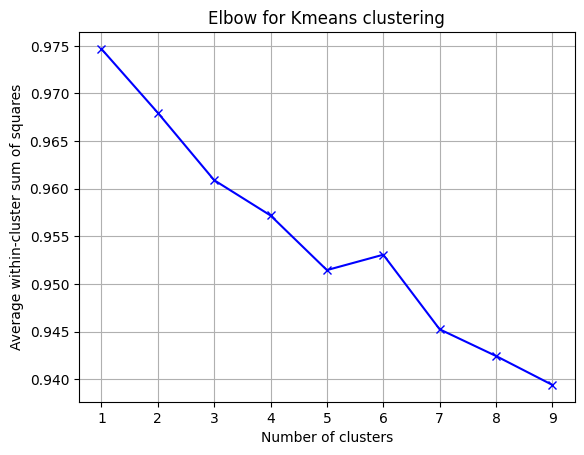

1
*************************
2
*************************
3
*************************
4
*************************
5
*************************
6
*************************
7
*************************


In [17]:
corpus_train = "corpus_train.txt"
cluster_docs = "cluster_result_document.txt"
cluster_keywords = "cluster_result_keyword.txt"
num_clusters = 7
tfidf_train,word_dict=tfidf_vector(corpus_train)
best_kmeans(tfidf_train,word_dict)
cluster_kmeans(tfidf_train,word_dict,cluster_docs,cluster_keywords,num_clusters)

build train-corpus done!!
the shape of train is 
(1610, 362)
1
2
3
4
5
6
7
8
9


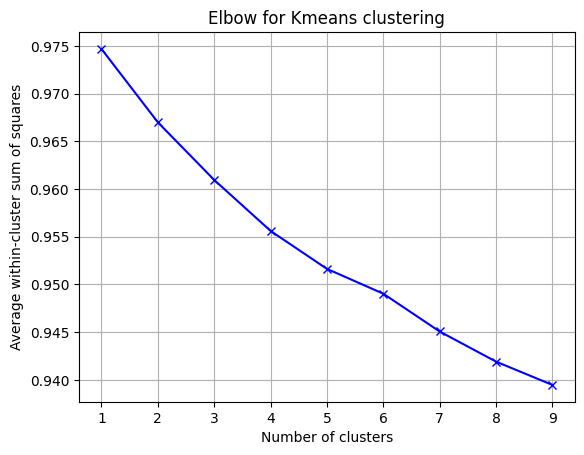

1
*************************
2
*************************
3
*************************
4
*************************
5
*************************
6
*************************
7
*************************


In [26]:
# 全部代码汇总
import os
import sys as sys

# reload(sys)
# sys.setdefaultencoding('utf-8')
from sklearn.cluster import KMeans
from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import numpy as np


def tfidf_vector(corpus_path):
    """
    文本向量化处理，生成TF-IDF特征矩阵和词汇表
    参数:
        corpus_path: 语料库文件路径
    返回:
        tfidf_train: TF-IDF特征矩阵
        word_dict: 词汇索引字典
    """
    corpus_train = []
    # 利用train-corpus提取特征
    target_train = []
    for line in open(corpus_path):
        line = line.strip().split("\t")
        if len(line) == 2:
            words = line[1]  # 文本内容
            category = line[0]  # 类别标签
            target_train.append(category)
            corpus_train.append(words)
    print("build train-corpus done!!")

    # 使用CountVectorizer进行词频统计
    count_v1 = CountVectorizer(
        max_df=0.4, min_df=0.01
    )  # 忽略出现在>40%文档或<1%文档的词
    counts_train = count_v1.fit_transform(corpus_train)  # 生成词频矩阵

    # 构建词汇索引字典
    word_dict = {}
    for index, word in enumerate(count_v1.get_feature_names_out()):
        word_dict[index] = word

    print("the shape of train is ")
    print(repr(counts_train.shape))

    # 将词频矩阵转换为TF-IDF矩阵
    tfidftransformer = TfidfTransformer()
    tfidf_train = tfidftransformer.fit(counts_train).transform(counts_train)
    return tfidf_train, word_dict


def cluster_kmeans(
    tfidf_train, word_dict, cluster_docs, cluster_keywords, num_clusters
):
    """
    K均值聚类并保存结果
    参数:
        tfidf_train: TF-IDF特征矩阵
        word_dict: 词汇索引字典
        cluster_docs: 文档聚类结果输出文件
        cluster_keywords: 聚类关键词结果输出文件
        num_clusters: 聚类数量
    """
    # 保存文档聚类结果
    f_docs = open(cluster_docs, "w+")
    km = KMeans(n_clusters=num_clusters)
    km.fit(tfidf_train)
    clusters = km.labels_.tolist()  # 获取每个文档的聚类标签

    cluster_dict = {}
    # 获取每个聚类的中心点排序(按重要性降序)
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]

    doc = 1
    # 写入文档聚类结果: 文档编号,所属聚类
    for cluster in clusters:
        f_docs.write(str(str(doc)) + "," + str(cluster) + "\n")
        doc += 1
        if cluster not in cluster_dict:
            cluster_dict[cluster] = 1
        else:
            cluster_dict[cluster] += 1
    f_docs.close()

    # 保存每个聚类的关键词
    cluster = 1
    f_clusterwords = open(cluster_keywords, "w+")
    for ind in order_centroids:  # 每个聚类选50个最具代表性的词
        words = []
        for index in ind[:50]:
            words.append(word_dict[index])  # 根据索引获取词汇
        print(cluster), (",".join(words))
        f_clusterwords.write(str(cluster) + "\t" + ",".join(words) + "\n")
        cluster += 1
        print("*****" * 5)
    f_clusterwords.close()


def best_kmeans(tfidf_matrix, word_dict):
    """
    使用肘部法则确定最佳聚类数量
    参数:
        tfidf_matrix: TF-IDF特征矩阵
        word_dict: 词汇索引字典
    """
    K = range(1, 10)  # 测试1-9个聚类
    meandistortions = []  # 保存每个K值的平均距离

    for k in K:
        print(k), ("****" * 5)
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(tfidf_matrix)
        # 计算平均距离(样本到最近聚类中心的距离)
        meandistortions.append(
            sum(
                np.min(
                    cdist(tfidf_matrix.toarray(), kmeans.cluster_centers_, "euclidean"),
                    axis=1,
                )
            )
            / tfidf_matrix.shape[0]
        )

    # 绘制肘部法则曲线
    plt.plot(K, meandistortions, "bx-")
    plt.grid(True)
    plt.xlabel("Number of clusters")
    plt.ylabel("Average within-cluster sum of squares")
    plt.title("Elbow for Kmeans clustering")
    plt.show()


# 主程序
corpus_train = "corpus_train.txt"  # 训练语料
cluster_docs = "cluster_result_document.txt"  # 文档聚类结果
cluster_keywords = "cluster_result_keyword.txt"  # 聚类关键词结果
num_clusters = 7  # 聚类数量

# 1. 文本向量化
tfidf_train, word_dict = tfidf_vector(corpus_train)

# 2. 使用肘部法则确定最佳聚类数(可视化)
best_kmeans(tfidf_train, word_dict)

# 3. 执行K均值聚类并保存结果
cluster_kmeans(tfidf_train, word_dict, cluster_docs, cluster_keywords, num_clusters)